In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
from tensorflow.keras import optimizers
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from pickle import dump
from pickle import load
from tensorflow.keras.models import load_model

In [4]:
df = pd.read_csv('Amrel NRM data for model building final with quadratic lining.csv')

df = df[df['Heat number (life number)']>1]    
df = df.reset_index(drop=True)
df['Number of capacitors removed'].fillna(0, inplace=True)

threshold = 150

for i in range(df.shape[0]):
    if(df.loc[i,'Total Heat Time previous (minutes)']>threshold):
        df.loc[i,'Total Heat Time previous (minutes)']= threshold
    if(df.loc[i,'Total Heat Time (minutes)']>threshold):
        df.loc[i,'Total Heat Time (minutes)']= threshold
        
df['Input energy previous (KWH)'] = df['Power previous']*df['Total Heat Time previous (minutes)']/60
df['Input energy (KWH)'] = df['Power']*df['Total Heat Time (minutes)']/60

In [5]:
df['Efficiency (MT/KWH)'] = df['Efficiency (MT/KWH)']*1000
df['Previous Output'] = df['Previous Output']*1000
df['Previous Input'] = df['Previous Input']*1000
df['Scrap (MT)'] = df['Scrap (MT)']*1000
df['Sponge (MT)'] = df['Sponge (MT)']*1000
df['Alloys (MT)'] = df['Alloys (MT)']*1000

In [6]:
model = load_model("model.h5")
scaler1 = load(open('scaler1.pkl', 'rb'))
scaler2 = load(open('scaler2.pkl', 'rb'))

In [7]:
from scipy.optimize import minimize, LinearConstraint
dfc = df[df['campaign']==8]
dfc = dfc.reset_index(drop=True)
R = np.array(dfc['Refractory lining before heating'])

In [8]:
# Setting initial condition

import random

randomlist = []
for i in range(dfc.shape[0]):
    n = random.randint(2,7)
    randomlist.append(np.abs(n))
# R0 = np.ones((dfc.shape[0],1))*4
# R0 = R
# R0 = np.zeros((dfc.shape[0],1))
R0 = randomlist

In [9]:
def objective_function(Coef):
    dfc['Refractory lining before heating'] = Coef
    
    input_columns = ['Scrap (MT)', 'Sponge (MT)', 'Hot Heel (MT)', 'Alloys (MT)','Number of capacitors removed','Tapping Temperature (C)','Refractory lining before heating',
             'Previous Voltage', 'Previous Frequency','Previous Input', 'Previous Output','Input energy previous (KWH)']
    output_columns = ['Efficiency (MT/KWH)']
    X = dfc[input_columns]
    X_test = X.iloc[:,:].values
    y = dfc[output_columns]
    y_test = y.iloc[:,:].values
    normalized_X_test = scaler1.transform(X_test)
    normalized_y_test = scaler2.transform(y_test)
    pred_test = model.predict(normalized_X_test)
    y_pred_test = scaler2.inverse_transform(pred_test)
    sum_of_squares = np.sum(np.square(y_test-y_pred_test))
    return sum_of_squares

In [10]:

def inequality(Coef):
    A = np.zeros((dfc.shape[0]-1,dfc.shape[0]))
    for i in range(dfc.shape[0]-1):
        A[i,i] = 1
        A[i,i+1] = -1

 
    return np.matmul(A,Coef)-0.01


def equality1(Coef):
    return Coef[0]-R[0]

def equality2(Coef):
    return Coef[-1]-R[-1]

bounds = [(2, 7) for _ in range(dfc.shape[0])]
con1 = {'type':'ineq','fun':inequality}
con2 = {'type':'eq', 'fun':equality1}
con3 = {'type':'eq', 'fun':equality2}



con = [con1, con2, con3]






In [11]:
res = minimize(objective_function, x0 = R0, constraints=con,bounds=bounds,method='SLSQP',
               options={'ftol': 1e-8, 'disp': True})
res

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.22855857314740685
            Iterations: 3
            Function evaluations: 196
            Gradient evaluations: 3


     fun: 0.22855857314740685
     jac: array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.81236137, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ])
 message: 'Optimization terminated successfully.'
    nfev: 196
     nit: 3
    njev: 3
  status: 0
 success: True
       x: array([6.74923856, 4.66000596,

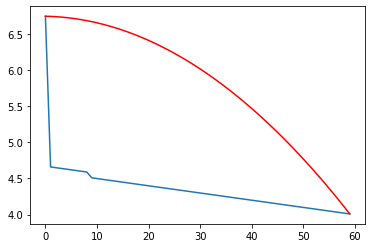

In [12]:
plt.figure()
plt.plot(res.x)
plt.plot(R,c='r')

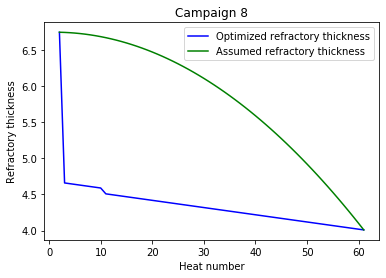

In [13]:
plt.plot(dfc['Heat number (life number)'],res.x,c='b');
plt.plot(dfc['Heat number (life number)'],R,c='g');
plt.xlabel('Heat number');
plt.ylabel('Refractory thickness');
plt.title('Campaign 8');
plt.legend(['Optimized refractory thickness','Assumed refractory thickness']);
plt.show();

In [14]:
res.x

array([6.74923856, 4.66000596, 4.64999922, 4.63993165, 4.62993165,
       4.61993165, 4.60993165, 4.59993165, 4.58993165, 4.50880172,
       4.49880172, 4.48880172, 4.47880172, 4.46880172, 4.45880172,
       4.44880172, 4.43880172, 4.42880172, 4.41880172, 4.40880172,
       4.39880172, 4.38880172, 4.37880172, 4.36880172, 4.35880172,
       4.34880172, 4.33880172, 4.32880172, 4.31880172, 4.30880172,
       4.29880172, 4.28880172, 4.27880172, 4.26880172, 4.25880172,
       4.24880172, 4.23880172, 4.22880172, 4.21880172, 4.20880172,
       4.19880172, 4.18880172, 4.17880172, 4.16880172, 4.15880172,
       4.14880172, 4.13880172, 4.12880172, 4.11880172, 4.10880172,
       4.09880172, 4.08880172, 4.07880172, 4.06880172, 4.05880172,
       4.04880172, 4.03880172, 4.02880172, 4.01880172, 4.00880172])

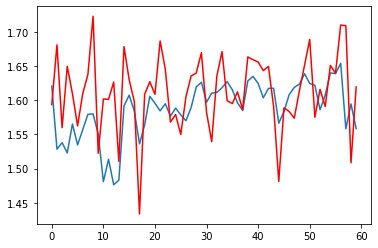

In [15]:
dfc['Refractory lining before heating'] = res.x

input_columns = ['Scrap (MT)', 'Sponge (MT)', 'Hot Heel (MT)', 'Alloys (MT)','Number of capacitors removed','Tapping Temperature (C)','Refractory lining before heating',
         'Previous Voltage', 'Previous Frequency','Previous Input', 'Previous Output','Input energy previous (KWH)']
output_columns = ['Efficiency (MT/KWH)']
X = dfc[input_columns]
X_test = X.iloc[:,:].values
y = dfc[output_columns]
y_test = y.iloc[:,:].values
normalized_X_test = scaler1.transform(X_test)
normalized_y_test = scaler2.transform(y_test)
pred_test = model.predict(normalized_X_test)
y_pred_test = scaler2.inverse_transform(pred_test)

plt.figure()

plt.plot(y_pred_test)
plt.plot(y_test,c='r')



In [16]:
dfc['Refractory lining before heating'] = R
input_columns = ['Scrap (MT)', 'Sponge (MT)', 'Hot Heel (MT)', 'Alloys (MT)','Number of capacitors removed','Tapping Temperature (C)','Refractory lining before heating',
             'Previous Voltage', 'Previous Frequency','Previous Input', 'Previous Output','Input energy previous (KWH)']
output_columns = ['Efficiency (MT/KWH)']
X = dfc[input_columns]
X_test = X.iloc[:,:].values
y = dfc[output_columns]
y_test = y.iloc[:,:].values
normalized_X_test = scaler1.transform(X_test)
normalized_y_test = scaler2.transform(y_test)
pred_test_prev = model.predict(normalized_X_test)
y_pred_test_prev = scaler2.inverse_transform(pred_test_prev)

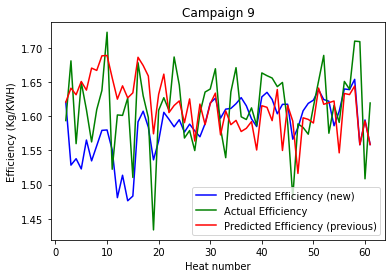

In [17]:
plt.plot(dfc['Heat number (life number)'],y_pred_test,c='b');
plt.plot(dfc['Heat number (life number)'],y_test,c='g');
plt.plot(dfc['Heat number (life number)'],y_pred_test_prev,c='r');
plt.xlabel('Heat number');
plt.ylabel('Efficiency (Kg/KWH)');
plt.title('Campaign 9');
plt.legend(['Predicted Efficiency (new)','Actual Efficiency','Predicted Efficiency (previous)']);
plt.show();

In [18]:
for i in range(1):
    print(output_columns[i])
    print("R2 score is {}".format(r2_score(y_test[:,i], y_pred_test[:,i])))
    print("Test NMSE score is {}".format(np.sum(np.square(y_pred_test[:,i]-y_test[:,i]))/np.sum(np.square(y_test[:,i]-np.mean(y_test[:,i])))*100))

Efficiency (MT/KWH)
R2 score is -0.26204669785016255
Test NMSE score is 126.20466978501625
